<a href="https://colab.research.google.com/github/patricksabry1/42028-Deep-Learning/blob/master/42028_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Pre-Processing

In [99]:
%pip install livelossplot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot import PlotLossesKerasTF
from tqdm import tqdm
from skimage import feature
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import accuracy_score
import cv2
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load MNIST dataset from gdrive path

In [0]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [4]:
cd /content/gdrive/My Drive/42028-DL-CNN-2020/assignment-1/

/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-1


## Load the dataset and store into train/test split variables

In [0]:
def loadData(reshape=True):
    X_train, y_train = load_mnist('/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-1/', kind='train')
    X_test, y_test = load_mnist('/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-1/', kind='t10k')

    # initialize the label names for MNIST digits
    labelNames = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

    X_norm = []
    X_test_norm =[]
    if reshape == True:
        X_train = X_train.reshape(-1,28,28,1)
        X_test = X_test.reshape(-1,28,28,1)
        print("Train dataset after reshaping:{}".format(np.shape(X_train)))
        print("Test dataset after reshaping :{}".format(np.shape(X_test)))

        # #convert to grayscale 
        # print("Converting train set to grayscale...")
        # for img_index in tqdm(range(len(X_train))):
        #     image = X_train[img_index]
        #     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #     X_norm.append(gray)

        # print("Converting test set to grayscale...")
        # for img_index in tqdm(range(len(X_test))):
        #     test_image = X_train[img_index]
        #     gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
        #     X_test_norm.append(gray)


    return X_train, y_train, X_test, y_test

## Visualise sample digits

In [56]:
X_train, y_train, X_test, y_test = loadData()

# view few images and print its corresponding label
img_index = 10
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.axis('off')
ax1.imshow(X_train[img_index])
print("Top left image label: " + str(labelNames[y_train[img_index]]))

ax2 = fig.add_subplot(2,2,2)
ax2.axis('off')
img_index = 1000
ax2.imshow(X_train[img_index])
print("Top right image label: " + str(labelNames[y_train[img_index]]))

ax2 = fig.add_subplot(2,2,3)
ax2.axis('off')
img_index = 10000
ax2.imshow(X_train[img_index])
print("Bottom left image label: " + str(labelNames[y_train[img_index]]))

ax2 = fig.add_subplot(2,2,4)
ax2.axis('off')
img_index = 20000
ax2.imshow(X_train[img_index])
print("Bottom right image label: " + str(labelNames[y_train[img_index]]))

  0%|          | 0/60000 [00:00<?, ?it/s]

Train dataset after reshaping:(60000, 28, 28)
Test dataset after reshaping :(10000, 28, 28)
Converting train set to grayscale...


error: ignored

## Extract Histogram-of-Oriented Gradient feature

The following utility function can be used to extract Histogram-of-gradients features for both train and test datasets.

In [0]:
def getHOG(X_train, y_train):
    # initialize the data matrix and labels
    print("Extracting features from training dataset...")
    hog_train = []
    hog_labels_train = []

    # loop over the training images
    for img_index in range(len(X_train)):
        # load the image, and extract HOG features
        image = (X_train[img_index])
        #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        H = feature.hog(image, orientations=9, pixels_per_cell=(10, 10),
                        cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")
        
        # update the data and labels
        hog_train.append(H)
        hog_labels_train.append(y_train[img_index])

    return hog_train, hog_labels_train

## Extract Local Binary Patterns feature
The following utility function can be used to extract Local Binary pattern features for both train and test datasets.

In [0]:
from skimage import feature
import numpy as np
import cv2

# Get LBP features for the dataset
class LocalBinaryPatterns:
	def __init__(self, numPoints, radius):
		# store the number of points and radius
		self.numPoints = numPoints
		self.radius = radius
 
	def LBPfeatures(self, image, eps=1e-7):
		# compute the Local Binary Pattern representation
		# of the image, and then use the LBP representation
		# to build the histogram of patterns
		lbp = feature.local_binary_pattern(image, self.numPoints,
			self.radius, method="uniform")
        # Form the histogram
		(hist, _) = np.histogram(lbp.ravel(),
			bins=np.arange(0, self.numPoints + 3),
			range=(0, self.numPoints + 2))
 
		# normalize the histogram
		hist = hist.astype("float")
		hist /= (hist.sum() + eps)
 
		# return the histogram of Local Binary Patterns
		return hist

def getLBPFeatures(X_train, y_train):
    # Create an object of LocalBinaryPatterns class and initial the parameters.
    desc = LocalBinaryPatterns(24, 8)
    lbp_train = []
    lbp_labels_train = []

    # loop over the training images
    for img_index in range(len(X_train)):
        # load the image, convert it to grayscale, and extract LBP features
        image = (X_train[img_index])
        hist = desc.LBPfeatures(image)
    
        # extract the label from the image path, then update the
        # label and data lists
        lbp_labels_train.append(y_train[img_index])
        lbp_train.append(hist)
            
    return lbp_train, lbp_labels_train

# SVM

## SVM fitted on LBP features

In [9]:
from sklearn.svm import LinearSVC
X_train, y_train, X_test, y_test = loadData()

lbp_train, lbp_labels_train, = getLBPFeatures(X_train, y_train)
print(np.shape(lbp_train))
print(np.shape(lbp_labels_train))

model = LinearSVC(C=10, random_state=42, max_iter=1000)
model.fit(lbp_train, lbp_labels_train)

# Check the training accuray
print("Train set Accuracy: {:.2f}".format(model.score(lbp_train, lbp_labels_train)))


(60000, 26)
(60000,)
Train set Accuracy: 0.45


## Evaluate SVM-LBP performance

In [10]:
desc = LocalBinaryPatterns(24, 8)
predictions=[]
predict_label=[]

# Exract LBP features for each test sample and classify it with the trained SVM classifier
for i in range(len(X_test)):
  image = X_test[i]
  # Extract LBP feature
  histo = desc.LBPfeatures(image)
  # Perform classification
  prediction = model.predict(histo.reshape(1, -1))
  # Store the classfication result
  predictions.append(prediction)
  predict_label.append(y_test[i])


accuracy = metrics.accuracy_score(y_test, predictions)
print("Accuracy on test dataset: " + str(accuracy))

Accuracy on test dataset: 0.4567


## SVM fitted on HOG features

In [17]:
X_train, y_train, X_test, y_test = loadData()

hog_train, hog_labels_train = getHOG(X_train, y_train)

model = svm.SVC(kernel='rbf', C=100.0, random_state=42)
model.fit(hog_train, hog_labels_train)

print("Train set Accuracy: {:.2f}".format(model.score(hog_train, hog_labels_train)))

Extracting features from training dataset...
[0.09659569 0.         0.07721877 0.11704273 0.11926587 0.01272765
 0.06865895 0.14045465 0.         0.12891422 0.11491048 0.09588846
 0.35328942 0.35328942 0.21053873 0.0709985  0.02330123 0.
 0.         0.         0.         0.         0.05770102 0.03437924
 0.         0.         0.         0.29771647 0.         0.25494882
 0.29916013 0.22818086 0.12765835 0.35328942 0.35328942 0.1673096 ]
Train set Accuracy: 0.99


## Evaluate SVM-HOG performance

### Confusion Matrix

Extracting features from test dataset...
Accuracy on test dataset: 0.9095


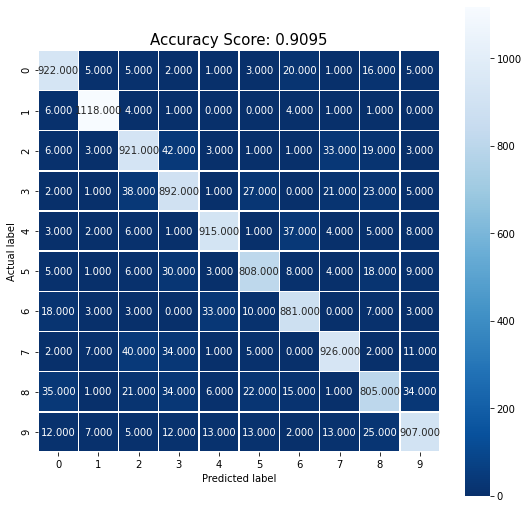

In [10]:
# initialize the data matrix and labels
print("Extracting features from test dataset...")
predict_test = []
hog_labels_test = []
hog_test=[]
# loop over the training images
for img_ind in range(len(X_test)):
  # load the image, and extract HOG features
  img=X_test[img_ind]
  H = feature.hog(img, orientations=9, pixels_per_cell=(10, 10),
                  cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")
  pred = model.predict(H.reshape(1, -1))[0]
  # update the data and labels
  predict_test.append(pred)
  hog_test.append(H)
  hog_labels_test.append(y_test[img_ind])

# Test set Accuracy
accuracy = metrics.accuracy_score(y_test, predict_test)
print("Accuracy on test dataset:",accuracy)

# Plot the confusion matrix
cm  = metrics.confusion_matrix(y_test, predict_test)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);

### Results visualisation

Image original label: 6 | Predicted label: 6
Image original label: 9 | Predicted label: 9
Image original label: 8 | Predicted label: 8
Image original label: 5 | Predicted label: 5


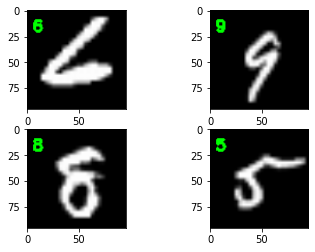

In [16]:
images = []
orig_labels = []
pred_labels = []

# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(y_test)), size=(16,)):
  # Fetch train image by index and compute HOG feature
  test_img = (X_test[i])
  H1 = feature.hog(test_img, orientations=9, pixels_per_cell=(10, 10),
                  cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")
  
  # Make prediction using trained model
  pred = model.predict(H1.reshape(1, -1))[0]
  
  # Fetch predicted label from labels array
  label = labelNames[pred]
  pred_labels.append(label)
  orig_labels.append(labelNames[y_test[i]])
  color = (0, 255, 0)
  test_img = cv2.merge([test_img] * 3)
  test_img = cv2.resize(test_img, (96, 96), interpolation=cv2.INTER_LINEAR)
  cv2.putText(test_img, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.50, color, 2)
  images.append(test_img)

# Plot four random test record predictions
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(images[1])
print("Image original label: " + str(orig_labels[1]) + " | Predicted label: " + str(pred_labels[1]))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(images[2])
print("Image original label: " + str(orig_labels[2]) + " | Predicted label: " + str(pred_labels[2]))
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(images[3])
print("Image original label: " + str(orig_labels[3]) + " | Predicted label: " + str(pred_labels[3]))
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(images[4])
print("Image original label: " + str(orig_labels[4]) + " | Predicted label: " + str(pred_labels[4]))


# KNN

## KNN fitted on LBP features

In [13]:
from sklearn.neighbors import KNeighborsClassifier
X_train, y_train, X_test, y_test = loadData()

lbp_train, lbp_labels_train = getLBPFeatures(X_train, y_train)
lbp_test, lbp_labels_test = getLBPFeatures(X_test, y_test)

k_vals = [1,2,5,15,30,60,100]
accuracies = []

for k in k_vals:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(lbp_train, lbp_labels_train)

    # evaluate the model and update the accuracies list
    score = model.score(lbp_test, lbp_labels_test)
    print("k=%d, accuracy=%.2f%%" % (k, score * 100))
    accuracies.append(score)

# find the most optimal value of k
i = int(np.argmax(accuracies))
print("k=%d achieved highest accuracy of %.2f%% on validation data" % (k_vals[i],
	accuracies[i] * 100))

k=1, accuracy=40.92%
k=2, accuracy=40.61%
k=5, accuracy=45.63%
k=15, accuracy=48.61%
k=30, accuracy=49.90%
k=60, accuracy=49.19%
k=100, accuracy=48.86%
k=30 achieved highest accuracy of 49.90% on validation data


## KNN fitted on HOG features

In [0]:
X_train, y_train, X_test, y_test = loadData()

hog_train, hog_labels_train = getHOG(X_train, y_train)

print(np.shape(hog_train))
print(np.shape(hog_labels_train))

k_vals = [1,2,5,15,30]
accuracies = []

for k in k_vals:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(hog_train, hog_labels_train)

    # evaluate the model and update the accuracies list
    score = model.score(hog_train, hog_labels_train)
    print("k=%d, accuracy=%.2f%%" % (k, score * 100))
    accuracies.append(score)

# find the most optimal value of k
i = int(np.argmax(accuracies))
print("k=%d achieved highest accuracy of %.2f%% on validation data" % (k_vals[i],
	accuracies[i] * 100))

Extracting features from training dataset...
(60000, 36)
(60000,)
k=1, accuracy=100.00%
k=2, accuracy=93.26%
k=5, accuracy=91.26%
k=15, accuracy=89.21%


# CNN

## Preprocess Data

* Normalise RGB values by dividing by 255.0
* OneHotEncode (1-of-K) label classes


In [78]:
import tensorflow as tf
def oneHotEncode(y, num_classes):
    y = tf.keras.utils.to_categorical(y, num_classes=num_classes)

    return y

def preprocessNetData():
    X_train, y_train, X_test, y_test = loadData()

    # Cast data to floats for floating point division
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')

    X_train = X_train / 255.0
    X_test = X_test / 255.0

    y_train = oneHotEncode(y_train, 10)
    y_test = oneHotEncode(y_test, 10)

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocessNetData()

Train dataset after reshaping:(60000, 28, 28)
Test dataset after reshaping :(10000, 28, 28)
60000 train samples
10000 test samples


## Augment manipulated image data using a data generator 
The data generator will apply a plethora of manipulations to the images including rotation, zooming, width and heigh shifting with varying degrees of intensity.
This will add variance to the dataset and allow for more robust classification. By using the Tensorflow data generator, these transformations are applied on the fly in batches during training to reduce memory overhead in exchange for a longer training time.

In [96]:
X_train, y_train, X_test, y_test = preprocessNetData()
    
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

datagen.fit(X_train)
train_generator = datagen.flow(X_train, y_train, batch_size=64, seed=42)

batch_size = 64
epochs = 20
steps_per_epoch = X_train.shape[0]/64

model = CNN(use_sgd=True)

# LR schedule - reduce learning rate on loss plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

callbacks = [PlotLossesKerasTF(), reduce_lr, tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]

hist = model.fit_generator(train_generator, epochs=20, steps_per_epoch=steps_per_epoch, verbose=1, validation_data=(X_test, y_test), shuffle=True,
                           callbacks=callbacks)

# Evaluate model performance using validation data
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(
    hist.history['val_loss'][-1],
    hist.history['val_accuracy'][-1]
))

Train dataset after reshaping:(60000, 28, 28, 1)
Test dataset after reshaping :(10000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_21 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_22 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
batch_normalization_23 (Batc (None, 12, 12, 32) 

NameError: ignored

## Convolutional Neural Network Architecture

In [0]:
import tensorflow as tf 

def CNN(use_sgd=False):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),


    tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='softmax')
    ])

    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    if use_sgd == True:
        sgd = tf.keras.optimizers.SGD(lr=0.03, momentum=0.9)
        
        model.compile(optimizer=sgd,
            loss=loss_fn,
            metrics=['accuracy'])
    else:

        model.compile(optimizer='adam',
                    loss=loss_fn,
                    metrics=['accuracy'])
    model.summary()

    return model

## Evaluate trained model on validation data

In [21]:
model.evaluate(X_test,  y_test, verbose=2)

# initialize the data matrix and labels
print("Extracting features from test dataset...")
predict_test = []
hog_labels_test = []
hog_test=[]
# loop over the training images
for img_ind in range(len(X_test)):
  # load the image, and extract HOG features
  img=X_test[img_ind]
  pred = model.predict(img.reshape(1, -1))[0]

  # update the data and labels
  predict_test.append(pred)

# Test set Accuracy
accuracy = metrics.accuracy_score(y_test, predict_test)
print("Accuracy on test dataset:",accuracy)

# Plot the confusion matrix
cm  = metrics.confusion_matrix(y_test, predict_test)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);

313/313 - 0s - loss: 0.3439 - accuracy: 0.9502
Extracting features from test dataset...


ValueError: ignored

# Results & Discussion